# Overview  
## Purpose  
This notebook provides a walkthrough of a "vanilla" analysis of scRNAseq data in scanpy. I've outlined some of the most general questions that a biologist may want to ask of the dataset, with comments for biological context and demo visualizations for each. This is intended to outline the "paths" a biologist may want to take through the cellxgene app, and scope out the most important questions for the tool to be able to address easily.  
  
Importantly, this analysis is replicated [here](https://docs.google.com/document/d/1nJIACHHs3PKB9VJ3T4yia4iqNQOq7yrE-M1uezc8_PU/edit) using cellxgene for as many steps as possible.  
  
## Analytical steps  
For each dataset, a standard analytical workflow may look like:  
1. Characterize the shape of the raw data  
2. Normalize the data  
3. Look at the distribution of the dataset overall. For high-dimensional datasets, this includes dimensionality reduction.  
4. Look at rows (cells): are there clusters? How defined are they? Do they correspond to "ground truth" characterizations?  
5. Look at columns (genes): are there covarying sets of genes? What do they do? Do these groups "make sense" biologically?  
6. Look at the relationship between rows (cells) and columns (genes): for a given cluster of cells, what genes make their expression profiles different from other cells? For a given gene, which cells express that gene? 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex, Normalize
%matplotlib inline
import scanpy.api as sc
import math
import random
from scipy import stats
from timeit import timeit
from itertools import combinations

sns.set(style='whitegrid', palette='Set2', font_scale=1.3)

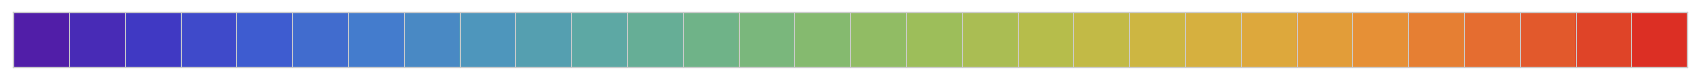

In [3]:
colors = ["#511EA8", "#482BB6", "#4039C3", "#3F4ACA", "#3E5CD0", "#416CCE", "#447CCD", "#4989C4", "#4E96BC", "#559FB0", "#5DA8A4", "#66AE96", "#6FB388", "#7AB77C", "#85BA6F", "#91BC64", "#9DBE5A", "#AABD53", "#B6BD4B", "#C2BA46", "#CDB642", "#D6B03F", "#DDA83C", "#E29D39", "#E69036", "#E67F33", "#E56D30", "#E2592C", "#DF4428", "#DC2F24"]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
palette = sns.color_palette(colors)
sns.set(style='whitegrid', font_scale=1.2)

sns.palplot(palette)

def assign_colors(vals, cmap=cmap):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    vals = set(vals)
    nvals = len(vals)
    
    colors = [cmap(i/nvals) for i in range(nvals)]
    
    return { val: colors[i] for i,val in enumerate(vals) }

## 1. Load & add default annotations to the raw data  

In [4]:
rawdata = sc.read('../data/Marrow-counts.csv').transpose() 
cell_annotation = pd.read_csv('../data/annotations_FACS.csv', index_col='cell') 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class

/Users/sidneybell/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 2. Normalize the data: filter to informative cells & genes, center & scale data

In [1]:
%time
'''
Their 'seurat' recipe for count normalization includes:
    pp.filter_cells(adata, min_genes=200) # drop cells with fewer than 200 genes expressed
    pp.filter_genes(adata, min_cells=3) # remove genes expressed in fewer than 3 cells
    pp.normalize_per_cell(adata, counts_per_cell_after=1e4) # each cell sums to 1
    filter_result = pp.filter_genes_dispersion(
        adata.X, min_mean=0.0125, max_mean=3, min_disp=0.5, log=not log) # remove uninformative genes
    adata._inplace_subset_var(filter_result.gene_subset)  
    if log: pp.log1p(adata) # log scale
    pp.scale(adata, max_value=10) # center + scale
'''

adata = sc.pp.recipe_seurat(rawdata, copy=True, log=False)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


NameError: name 'sc' is not defined

## 2.5 Preprocess the data: compute PCs, build neighbor graph, and infer clusters

In [16]:
## preprocess the data (this is the major timesuck of the whole operation)
%time 
sc.pp.pca(adata)
%time
sc.pp.neighbors(adata)

%time
sc.tl.louvain(adata)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 11 µs
CPU times: user 25 µs, sys: 3 µs, total: 28 µs
Wall time: 7.87 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 34.1 µs


## This brings us to the point where cellxgene intercepts the user.

## 3. Look at the distribution of the dataset overall  

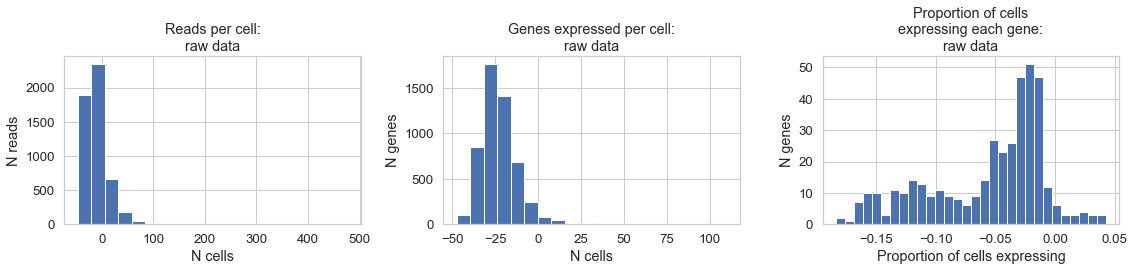

In [17]:
df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

nonzero_finite = df.mask((df.values > 0) & (np.isfinite(df.values)), other=1) # anything with finite value > 0 becomes 1
zero_nonfinite = df.mask((df.values < 1) | (~np.isfinite(df.values)), other=1) # any value < 1 or with non-finite value becomes 1

fig, ax = plt.subplots(ncols=3,nrows=1, figsize=(16,4))

reads_per_cell = df.sum(axis=1)
plt.sca(ax[0])
plt.hist(reads_per_cell.values, bins=20)
ax[0].set_title('Reads per cell:\nraw data')
ax[0].set_xlabel('N cells')
ax[0].set_ylabel('N reads')

genes_per_cell = nonzero_finite.sum(axis=1)
plt.sca(ax[1])
plt.hist(genes_per_cell.values, bins=20)
ax[1].set_title('Genes expressed per cell:\nraw data')
ax[1].set_xlabel('N cells')
ax[1].set_ylabel('N genes')

pCells_per_gene = nonzero_finite.sum(axis=0)/len(nonzero_finite.index.values)
plt.sca(ax[2])
plt.hist(pCells_per_gene.values, bins=30)
ax[2].set_title('Proportion of cells\nexpressing each gene:\nraw data')
ax[2].set_ylabel('N genes')
ax[2].set_xlabel('Proportion of cells expressing')

plt.tight_layout()
plt.show()

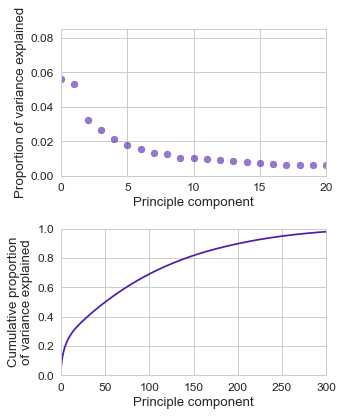

## 4. Look at rows (cells)  
### Are there clusters? How defined are they? Do they correspond to "ground truth" characterizations?

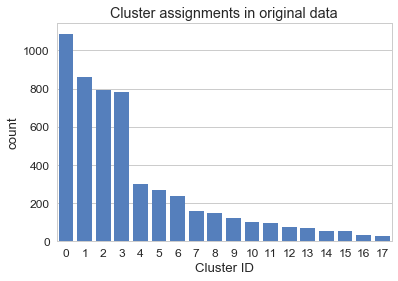

<Figure size 432x288 with 0 Axes>

In [9]:
ax = sns.countplot(adata.obs['louvain'], order = adata.obs['louvain'].value_counts().index, color = cmap(.2))
ax.set_xlabel('Cluster ID')
ax.set_title('Cluster assignments in original data')
plt.show()
plt.clf()

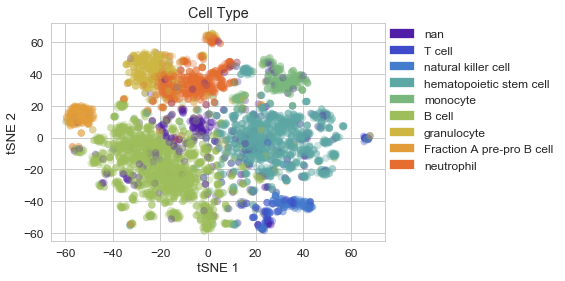

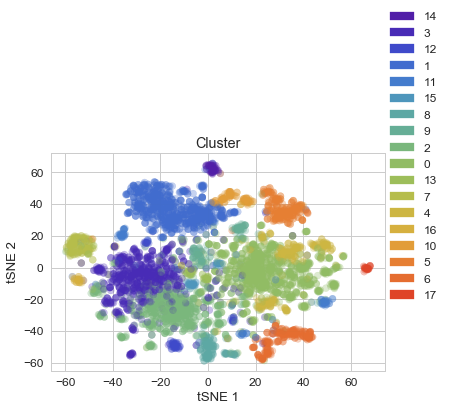

In [10]:
def plot_tsne(adata, colorby, title=None, cmap=cmap):
    ''' Plot tSNE colored by metadata field indicated in colorby. 
        Expects to find tSNE coordinates in adata.obsm['X_tsne'] 
        and metadata in adata.obs[colorby]'''
    
    sns.set(style='whitegrid', font_scale=1.2)
    fig, ax = plt.subplots()
    x = adata.obsm['X_tsne'][:,0]
    y = adata.obsm['X_tsne'][:,1]
    
    if colorby:
        if colorby in adata.obs:
            color_map = assign_colors(pd.unique(adata.obs[colorby]), cmap)
            colors = [color_map[x] if x in color_map else (.211,.211,.211,0.1) for x in adata.obs[colorby].values ]
            legend_handles = []
            for val, color in color_map.items():
                patch = mpatches.Patch(color=color, label=val)
                legend_handles.append(patch)
            plt.legend(loc=(1,.3),handles=legend_handles)

        else:
            gene_idx = adata.var_names.tolist().index(colorby)
            gene_expr_vals = adata.X[:,gene_idx]
            colors = [ cm.viridis_r(i / max(gene_expr_vals)) for i in gene_expr_vals ]
            norm = Normalize(vmin=min(gene_expr_vals),vmax=max(gene_expr_vals))
            sm = cm.ScalarMappable(cmap='viridis_r', norm=norm)
            sm.set_array([])
            plt.colorbar(sm)
    else:
        colors = ['lightgray' for x in adata.obs_names.values]
    ax.scatter(x, y, c=colors, alpha=0.3)
    ax.set_xlabel('tSNE 1')
    ax.set_ylabel('tSNE 2')
    
    
    if title:
        ax.set_title(title)
    plt.show()

sc.tl.tsne(adata, perplexity=len(pd.unique(adata.obs['cell_type'])),learning_rate=1000)
plot_tsne(adata, colorby='cell_type', title='Cell Type', cmap=cmap)
plot_tsne(adata, colorby='louvain', title='Cluster', cmap=cmap)

In [11]:
# def calc_mutual_information(clusters, classes):
#     assert clusters.index.tolist() == classes.index.tolist()
#     I = 0. # mutual information, summed over all clusters + classes
#     N = len(clusters) # N observations
    
#     K = pd.unique(clusters.values) # cluster bins
#     J = pd.unique(classes.values) # class bins (e.g., cell types)
#     for (k, j) in list(combinations(K,J,2)):
#         k_cells = set(clusters.loc[clusters.values == k].index) # cells in k bin
#         j_cells = set(classes.loc[classes.values==j].index) # cells in j bin
        
#         p_kj = len(k_cells.intersection(j_cells)) / N # rel freq of a cell being in both class k and cluster j
#         p_k = len(k_cells) / N # rel freq of a cell being in k
#         p_j = len(j_cells) / N # rel freq of a cell being in j
        
#         I_kj = p_kj * np.log(p_kj / (p_k*p_j)) # mutual information between cluster k and class j
#         I += I_kj # add to running total
#     return I
        
# def calc_entropy(labels):
#     H = 0.
#     N = len(labels)
    
#     for k in labels:
#         k_cells = set(labels.loc[labels.values == k].index)
#         p_k = len(k_cells) / N
#         H_k = -1.*p_k*np.log(p_k)
#         H += H_k
#     return H
    
# def calc_normalized_mutual_information(clusters, classes):    
#     mutual_information = calc_mutual_information(clusters, classes)
#     entropy_norm = (calc_entropy(clusters) + calc_entropy(classes)) / 2
#     return mutual_information / entropy_norm

# def calc_cluster_purity(cluster_val, clusters, classes):
#     assert clusters.index.tolist() == classes.index.tolist()
    
#     cluster = clusters.loc[clusters.values == cluster_val]
#     cluster_idx = set(cluster.index.values)
    
#     class_distrib = pd.value_counts(classes[cluster_idx])
#     most_common_class = class_distrib.index[0]
    
#     p_k = 
    
# clusters = demo.obs['louvain']
# classes = demo.obs['cell_type']
# calc_cluster_purity('0', clusters, classes)

## 5. Look at columns (genes)  
### Are there covarying sets of genes? What do they do? Do these groups "make sense" biologically?  
  
#### [Add this later]

### 6. Look at the relationship between columns (genes) and rows (cells)  
#### Which genes are differentially expressed in a given cell cluster?  
#### Which cells express my-favorite-gene?  


#### Scanpy does not provide a method for computing differential expression.  
Ambrose recommends [MAST](https://bioconductor.org/packages/release/bioc/html/MAST.html), but notes this is a very slow computation. In the mean time, the following is a nice ttest implementation pulled from Charlotte's cellxgene-rest-api code  

In [12]:
def diffexp(expression_1, expression_2, genes, pval=0.001, num_genes=20):
    """
    get top expressed genes from two different cell sets (uses t-test)
    :param expression_1: numpy expression array cell set 1
    :param expression_2: numpy expression array cell set 2
    :param pval: stats limit
    :param num_genes: number of genes to limit results to
    :return: Top genes and mean expression, pvalue, and average difference
     between cell set1 to cell set 2 for each gene in both cell sets
     sorted by t-test value
    """
    diff_exp = stats.ttest_ind(expression_1, expression_2)
    set1 = np.logical_and(diff_exp.pvalue < pval, diff_exp.statistic > 0)
    set2 = np.logical_and(diff_exp.pvalue < pval, diff_exp.statistic < 0)
    stat1 = diff_exp.statistic[set1]
    stat2 = diff_exp.statistic[set2]
    sort_set1 = np.argsort(stat1)[::-1]
    sort_set2 = np.argsort(stat2)
    pval1 = diff_exp.pvalue[set1][sort_set1]
    pval2 = diff_exp.pvalue[set2][sort_set2]
    mean_ex1_set1 = np.mean(expression_1[:, set1], axis=0)[sort_set1]
    mean_ex2_set1 = np.mean(expression_2[:, set1], axis=0)[sort_set1]
    mean_ex1_set2 = np.mean(expression_1[:, set2], axis=0)[sort_set2]
    mean_ex2_set2 = np.mean(expression_2[:, set2], axis=0)[sort_set2]
    mean_diff1 = mean_ex1_set1 - mean_ex2_set1
    mean_diff2 = mean_ex1_set2 - mean_ex2_set2
    genes_cellset_1 = np.array([genes[idx] for idx, val in enumerate(set1) if val])[sort_set1]
    genes_cellset_2 = np.array([genes[idx] for idx, val in enumerate(set2) if val])[sort_set2]
    return {
        "celllist1": {
            "topgenes": genes_cellset_1.tolist()[:num_genes],
            "mean_expression_cellset1": mean_ex1_set1.tolist()[:num_genes],
            "mean_expression_cellset2": mean_ex2_set1.tolist()[:num_genes],
            "pval": pval1.tolist()[:num_genes],
            "ave_diff": mean_diff1.tolist()[:num_genes]
        },
        "celllist2": {
            "topgenes": genes_cellset_2.tolist()[:num_genes],
            "mean_expression_cellset1": mean_ex1_set2.tolist()[:num_genes],
            "mean_expression_cellset2": mean_ex2_set2.tolist()[:num_genes],
            "pval": pval2.tolist()[:num_genes],
            "ave_diff": mean_diff2.tolist()[:num_genes]
        },
    }

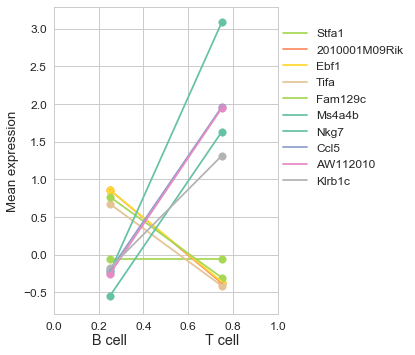

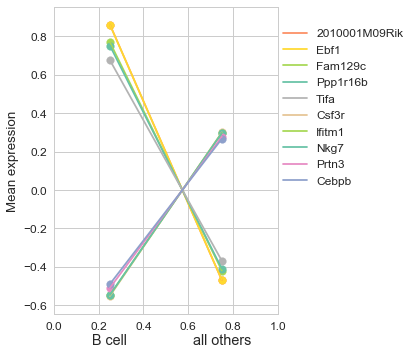

In [13]:
def compare_cell_sets(adata, cluster1_label, cluster2_label=None, cluster_key='louvain'):
    idx1 = adata.obs[cluster_key] == cluster1_label
    cluster1 = adata.X[idx1]
    
    if not cluster2_label:
        idx2 = adata.obs[cluster_key] != cluster1_label ## If no second set provided, compare to all others
        cluster2_label='all others'
    else:
        idx2 = adata.obs[cluster_key] == cluster2_label
    cluster2 = adata.X[idx2]
    
    genes = adata.var_names
    full_de = diffexp(cluster1, cluster2,genes=genes, num_genes=5)
    de = pd.DataFrame(full_de['celllist1']).append(pd.DataFrame(full_de['celllist2']))
    de.rename(columns={'mean_expression_cellset1': cluster1_label, 
                       'mean_expression_cellset2': cluster2_label},
             inplace=True)    
    de = de.set_index('topgenes')

    fig, ax = plt.subplots(figsize=(6, 5))
    pval_cutoff = 0.001
    
    colors = assign_colors(set(de.index.values), 'Set2')
    for gene, vals in de.iterrows():
        c = colors[gene]
        x1, x2 = 0.25, 0.75
        y1, y2 = vals[cluster1_label], vals[cluster2_label]
        ax.scatter(x1, y1, s=60, c=c)
        ax.scatter(x2, y2, s=60, c=c)
        ax.plot([0.25, 0.75], [vals[cluster1_label], vals[cluster2_label]], c=c, label=gene)
        
    ax.text(0.25, -0.1, cluster1_label,transform=ax.transAxes, ha='center')
    ax.text(0.75,-0.1, cluster2_label, transform=ax.transAxes, ha='center')
    ax.set_ylabel('Mean expression')
    plt.legend(loc=(1,.4), bbox_transform=ax.transAxes,)
        
    ax.set_xlim(0,1)
    plt.tight_layout()
    plt.show()
    return full_de

# compare_cell_sets(adata, '0', None)

B_T_cell = compare_cell_sets(adata, 'B cell', 'T cell', cluster_key='cell_type')
B_cell = compare_cell_sets(adata, 'B cell', cluster_key='cell_type')

In [14]:
## Eventually, add a cell here showing gene ontology terms for enriched genes. 

## Perhaps also try a GO enrichment analysis on the counts matrix (i.e., which processes are upregulated in cell type X)